In [2]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import wave
#import pyaudio
import numpy as np
#import sounddevice as sd
import cv2
from scipy.signal import iirnotch, filtfilt
from glob import glob

In [5]:
subject_dirs = glob('/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5447527/*')
subject_dirs

['/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5447527/P5447527_20241120_115443.mff',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5447527/sub-P5447527_task-CUNY_run-001_video.avi',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5447527/sub-P5447527_task-CUNY_run-001_physio.h5',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5447527/sub-P5447527_task-CUNY_run-001_behavior.csv',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5447527/sub-P5447527_task-CUNY_run-001_behavior.log',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5447527/sub-P5447527_task-CUNY_run-001_mic.wav',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5447527/sub-P5447527_task-CUNY_run-001_behavior.psydat',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5447527/sub-P5447527_task-CUNY_run-001_eyes.csv']

# Load Data

In [6]:
xdf_path =  '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf'
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]
streams_collected

['Stimuli_Markers',
 'EGI NetAmp 0',
 'Tobii',
 'WebcamStream',
 'OpenSignals',
 'Microphone']

# Stimulus

In [7]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_ExperimentStart',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_ExperimentEnd',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,2.000000e+02,Onset_ExperimentStart,168134.439458,0.000000e+00
1,1.732122e+09,psychopy_time_stamp,168134.439469,1.089997e-08
2,1.000000e+01,Onset_RestingState,168166.501883,3.206242e-02
3,1.732122e+09,psychopy_time_stamp,168166.501902,3.206244e-02
4,1.100000e+01,Offset_RestingState,168466.500184,3.320607e-01
...,...,...,...,...
256,1.732125e+09,psychopy_time_stamp,170569.398005,2.434959e+00
257,2.010000e+02,Offset_ExperimentEnd,170574.399830,2.439960e+00
258,1.732125e+09,psychopy_time_stamp,170574.399839,2.439960e+00
259,4.000000e+00,Bx_input,170574.399887,2.439960e+00


In [8]:
# Function to calculate time between two triggeres

def get_secs_between_triggers(trigger1, trigger2):
    return stim_df.loc[stim_df.trigger == trigger1, 'lsl_time_stamp'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'lsl_time_stamp'].values[0]

In [9]:
# confirm all events are in the stim_df
evs = stim_df.loc[stim_df.event != 'psychopy_time_stamp']
evs

,trigger,event,lsl_time_stamp,time
0,200.0,Onset_ExperimentStart,168134.439458,0.000000
2,10.0,Onset_RestingState,168166.501883,0.032062
4,11.0,Offset_RestingState,168466.500184,0.332061
6,500.0,Onset_StoryListening,168466.500249,0.332061
8,100.0,Onset_10second_rest,168530.084336,0.395645
...,...,...,...,...
251,401.0,Offset_impedanceCheck,170234.234334,2.099795
253,80.0,Onset_SocialTask,170268.901511,2.134462
255,81.0,Offset_SocialTask,170569.397985,2.434959
257,201.0,Offset_ExperimentEnd,170574.399830,2.439960


In [10]:
#Get a list of the story names using the events dict
story_names = [x.split('_')[1] for x in list(events.values())[2:][::2]]
story_names

['RestingState',
 'StoryListening',
 '10second',
 'CampFriend',
 'FrogDissection',
 'DanceContest',
 'ZoomClass',
 'Tornado',
 'BirthdayParty',
 'subjectInput',
 'FavoriteStory',
 'WorstStory',
 'impedanceCheck',
 'SocialTask']

In [11]:
def get_event_data(event, df, stim_df=stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]




# Physio

In [12]:
PS = data[streams_collected.index('OpenSignals')]
# Get the column names
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['time'] = (PS['time_stamps'] - PS['time_stamps'][0])/1000
sampling_rate = int(PS['info']['nominal_srate'][0])

In [ ]:
    
'''
# Plot every column in one plot
plt.figure(figsize=(20,10))
for col in ps_df.columns:
    plt.plot(ps_df['time'], ps_df[col])
plt.show()
'''
#f, ax = plt.subplots(figsize=(20,20), nrows=4, ncols=1)
f, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
#for i, col in enumerate(['RESPIRATION0', 'fSpO21', 'fSpO22', '%SpO23']):
for i, col in enumerate(column_labels):
    

    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=ps_df, x='time', y=col, ax=ax[i])

    # Place and Vline at every event in evs with onset and offset
    for event in evs.iterrows():
        # If the word Onset or Offset is in the event, plot a vertical line at the time of the event

        if "Onset" in event[1]['event'] or "Offset" in event[1]['event']:
            ax[i].axvline(event[1]['time'], color='r')
            ax[i].text(event[1]['time'], 0, event[1]['event'], rotation=90)
        
    #plt.title(col)
    #plt.show()

In [ ]:
physio_resting_state = get_event_data('RestingState', ps_df)
fig, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
#for i, col in enumerate(['RESPIRATION0', 'fSpO21', 'fSpO22', '%SpO23']):
for i, col in enumerate(column_labels):
    

    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=physio_resting_state[:5000], x='time', y=col, ax=ax[i])

In [20]:
ecg_df = ps_df[['ECG1', 'lsl_time_stamp', 'time']]
ecg_df

,ECG1,lsl_time_stamp,time
0,-0.00593,168131.660904,0.000000
1,-0.00216,168131.662904,0.000002
2,0.00198,168131.664905,0.000004
3,0.00521,168131.666905,0.000006
4,0.00916,168131.668905,0.000008
...,...,...,...
1251963,0.10045,170635.898877,2.504238
1251964,0.09919,170635.900877,2.504240
1251965,0.09937,170635.902878,2.504242
1251966,0.09955,170635.904878,2.504244


## ECG

<Axes: xlabel='time', ylabel='ECG1'>

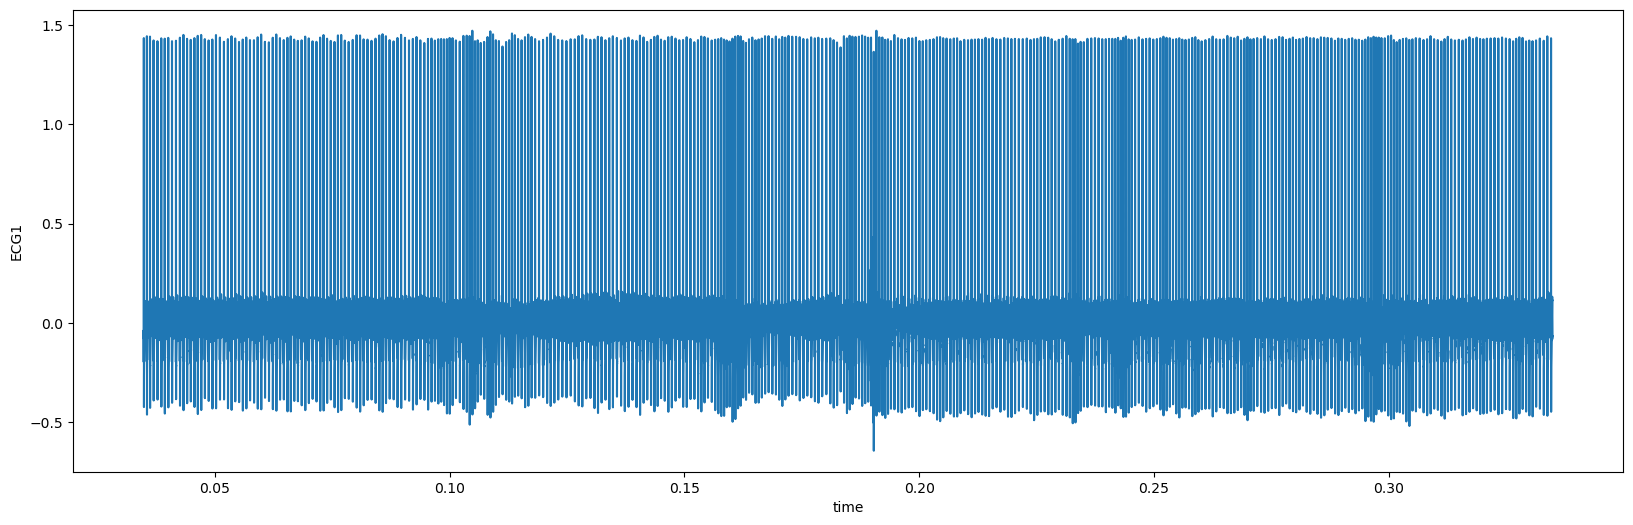

In [21]:
ecg_resting_state = get_event_data('RestingState', ecg_df)
fig, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data=ecg_resting_state, x='time', y='ECG1')


### QC using neurokit2 package

In [22]:
import neurokit2 as nk

#### ecg_process() - automated pipeline for preprocessing ECG signal, cleaning uses neurokit method

In [23]:
ecg_signals, info = nk.ecg_process(ecg_resting_state['ECG1'], sampling_rate=sampling_rate)
ecg_signals

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,-0.06559,-0.023374,81.495557,0.810967,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,-0.05804,-0.023230,81.495557,0.810967,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,-0.04977,-0.023132,81.495557,0.810967,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,-0.04995,-0.023270,81.495557,0.810967,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,-0.06325,-0.023644,81.495557,0.810967,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149975,-0.06810,0.047551,75.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
149976,-0.06918,0.047330,75.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
149977,-0.06469,0.047258,75.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
149978,-0.07439,0.047077,75.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


### ECG report plot 

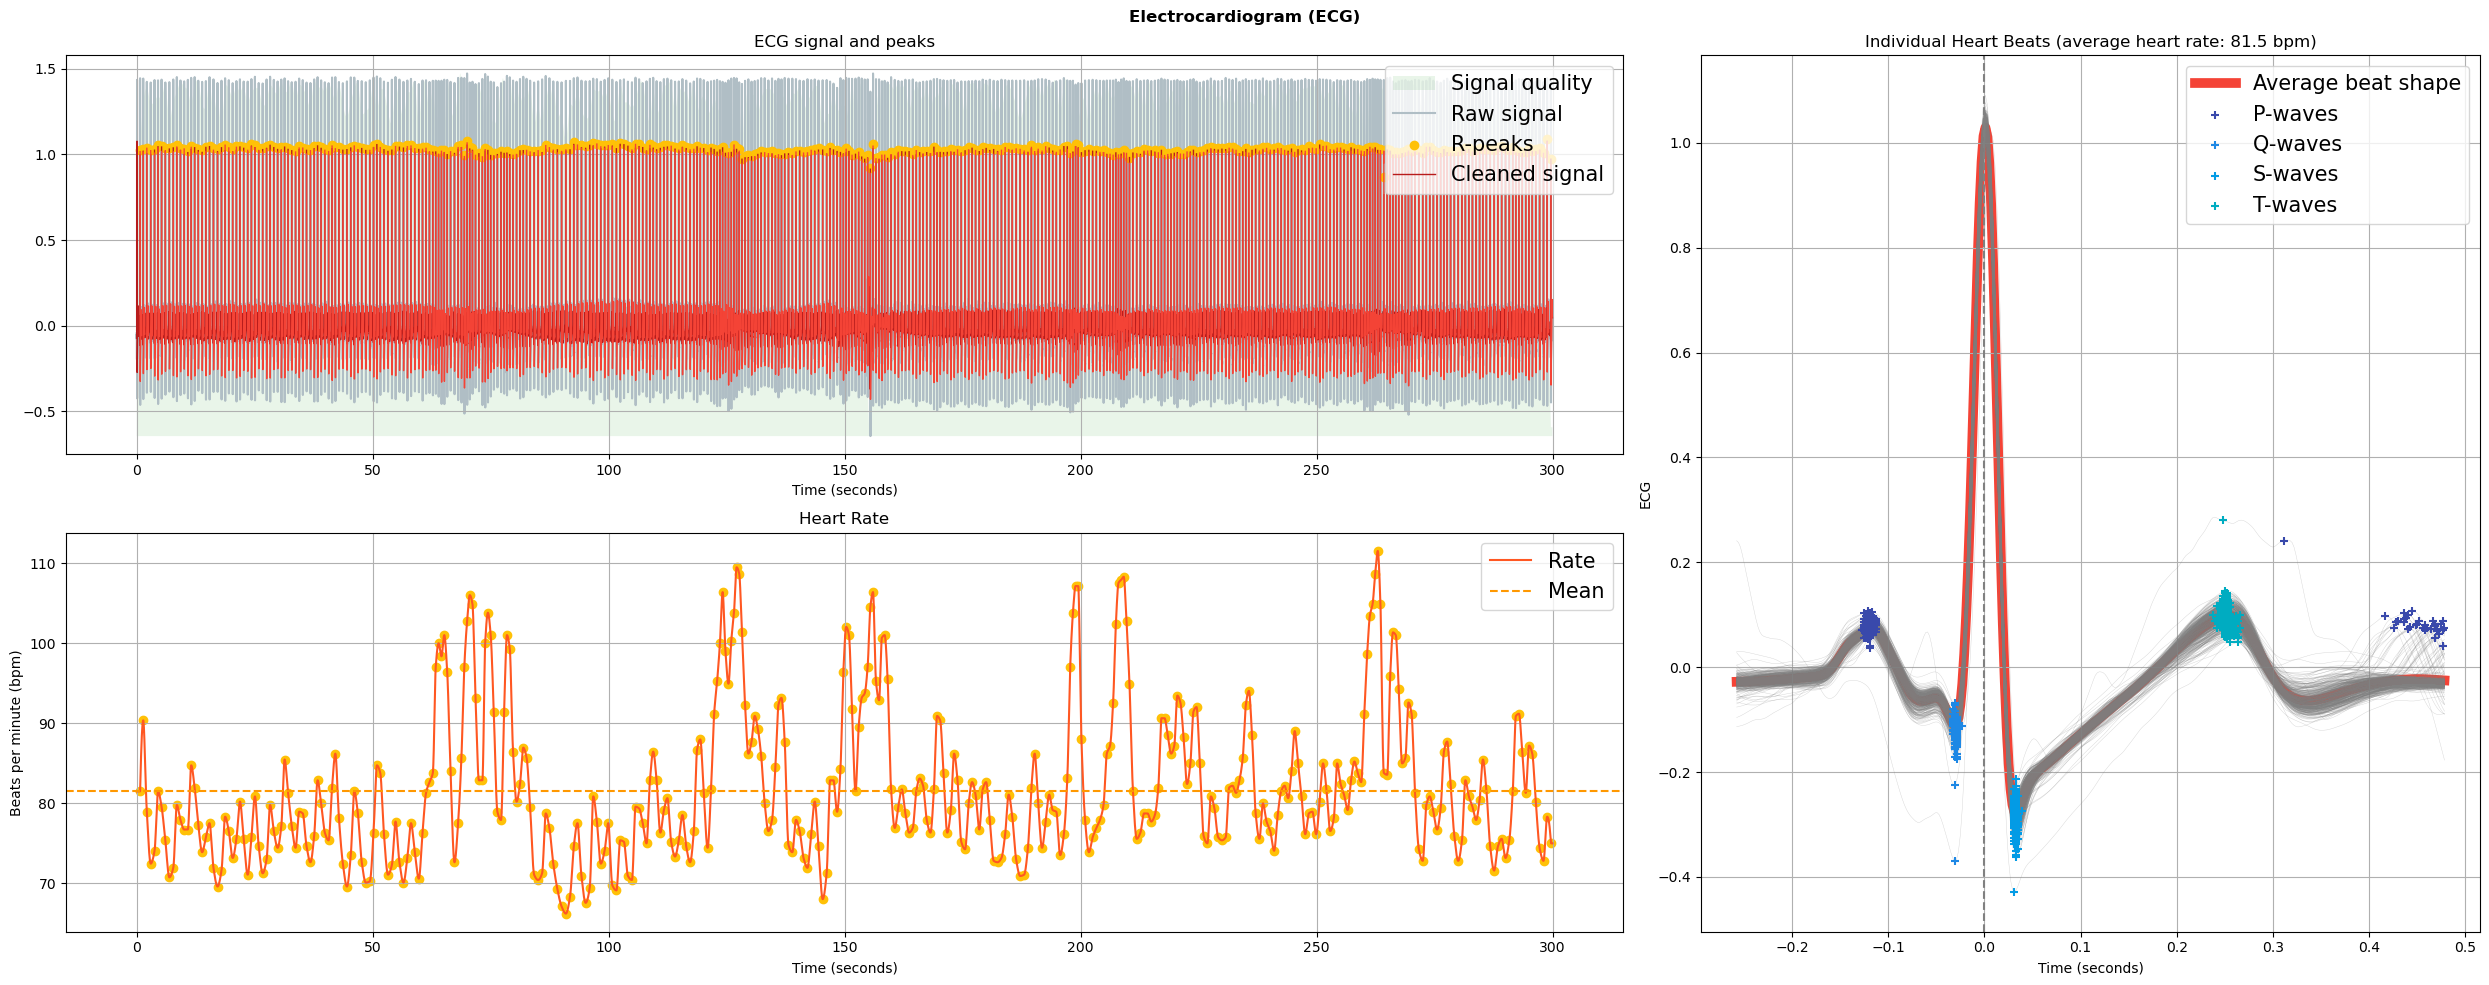

In [25]:
nk.ecg_plot(ecg_signals, info)
# Get the current figure and axes
fig = plt.gcf()
axes = fig.get_axes()
fig.set_size_inches(25, 10)
# Adjust layout to prevent overlap
plt.tight_layout()

# Iterate over each axis and move the legend
for i, ax in enumerate(axes):
    if i == 0:  # Check if it is the first plot (index 0)
        ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=15)  # Move legend outside the plot
    elif i == 1:  # Check if it is the second plot (index 1)
        ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=15)  # Move legend outside the plot
    elif i == 2:  # Check if it is the third plot (index 2)
        ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=15)  # Move legend to the right
    else:
        ax.legend(loc='center right', bbox_to_anchor=(1, 0.5), fontsize=15)  # Default position for other plots


# Add grid for better readability
for ax in axes:
    ax.grid(True)

# Show the plot
plt.show()

### ecg_quality()

In [26]:
ecg_cleaned = nk.ecg_clean(ecg_resting_state['ECG1'], sampling_rate=sampling_rate, method='neurokit')


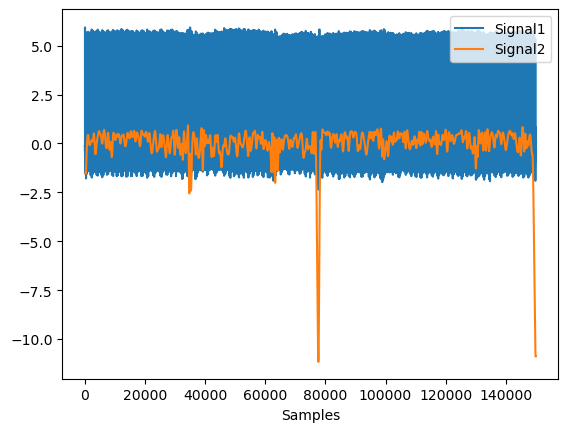

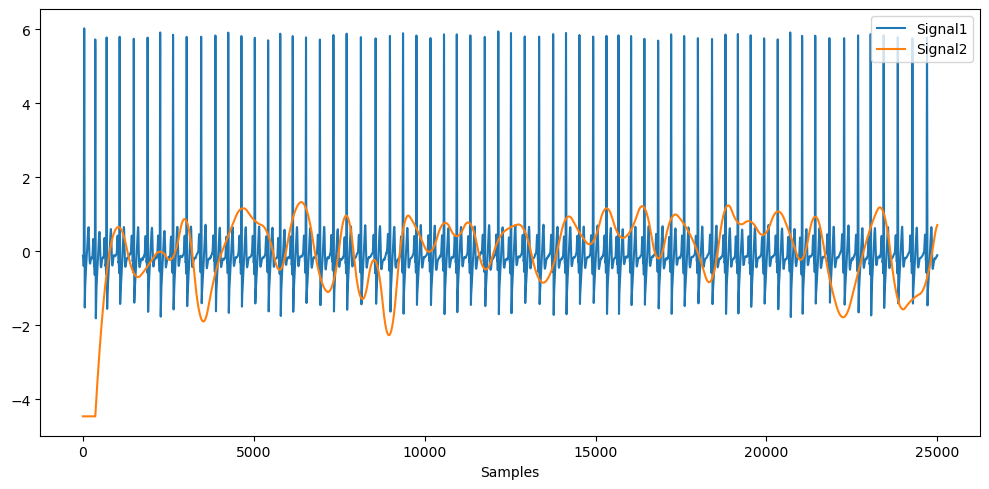

In [27]:
# Average QRS
quality = nk.ecg_quality(ecg_cleaned, sampling_rate=sampling_rate)
nk.signal_plot([ecg_cleaned, quality], standardize=True)

# Magnified plot for average QRS
quality = nk.ecg_quality(ecg_cleaned, sampling_rate=sampling_rate)
nk.signal_plot([ecg_cleaned[:25000], quality[:25000]], standardize=True)
# Get the current figure and axes
fig = plt.gcf()
axes = fig.get_axes()
fig.set_size_inches(10, 5)
# Adjust layout to
#  prevent overlap
plt.tight_layout()

In [28]:
# Zhao 2018 - Calculation of SQIs and Classification using Simple Heuristic fusion method (other method - Fuzzy comprehensive evaluation)
quality = nk.ecg_quality(ecg_cleaned,
               sampling_rate=sampling_rate,
               method="zhao2018",
               approach="simple")
print(quality)

Excellent


### Extract SQI from ecg_quality() function - kSQI, pSQI, basSQI

In [32]:
import scipy

def _ecg_quality_kSQI(ecg_cleaned, method="fisher"):
    """Return the kurtosis of the signal, with Fisher's or Pearson's method."""

    if method == "fisher":
        return scipy.stats.kurtosis(ecg_cleaned, fisher=True)
    elif method == "pearson":
        return scipy.stats.kurtosis(ecg_cleaned, fisher=False)

kSQI = _ecg_quality_kSQI(ecg_cleaned, method='fisher')
print('kSQI value is: ', kSQI)

kSQI value is:  15.990898661006792


In [94]:
from neurokit2.signal import signal_power

def _ecg_quality_pSQI(
    ecg_cleaned,
    sampling_rate=sampling_rate,
    window=1024,
    num_spectrum=[5, 15],
    dem_spectrum=[5, 40],
    **kwargs
):
    """Power Spectrum Distribution of QRS Wave."""

    psd = signal_power(
        ecg_cleaned,
        sampling_rate=sampling_rate,
        frequency_band=[num_spectrum, dem_spectrum],
        method="welch",
        normalize=False,
        window=window,
        **kwargs
    )

    num_power = psd.iloc[0, 0]
    dem_power = psd.iloc[0, 1]

    return num_power / dem_power

pSQI = _ecg_quality_pSQI(ecg_cleaned, sampling_rate=sampling_rate)
print('pSQI value is: ', pSQI)

pSQI value is:  0.7390957337040305


In [95]:
from neurokit2.signal import signal_power

def _ecg_quality_basSQI(
    ecg_cleaned,
    sampling_rate=sampling_rate,
    window=1024,
    num_spectrum=[0, 1],
    dem_spectrum=[0, 40],
    **kwargs
):
    """Relative Power in the Baseline."""
    psd = signal_power(
        ecg_cleaned,
        sampling_rate=sampling_rate,
        frequency_band=[num_spectrum, dem_spectrum],
        method="welch",
        normalize=False,
        window=window,
        **kwargs
    )

    num_power = psd.iloc[0, 0]
    dem_power = psd.iloc[0, 1]

    return (1 - num_power) / dem_power

basSQI = _ecg_quality_basSQI(ecg_cleaned, sampling_rate=sampling_rate)
print('basSQI value is: ', basSQI)

basSQI value is:  30.242924221807808


In [63]:
def classify(kSQI, pSQI, basSQI, sampling_rate, rpeaks):
    # Get the maximum bpm
    if len(rpeaks) > 1:
        ecg_rate = 60000.0 / (1000.0 / sampling_rate * np.min(np.diff(rpeaks)))
        #ecg_rate = nk.signal_rate(rpeaks, sampling_rate=sampling_rate, desired_length=len(rpeaks))
    else:
        ecg_rate = 1

            # pSQI classification
    if ecg_rate < 130:
        l1, l2, l3 = 0.5, 0.8, 0.4
    else:
        l1, l2, l3 = 0.4, 0.7, 0.3

    if pSQI > l1 and pSQI < l2:
        pSQI_class = 2
    elif pSQI > l3 and pSQI < l1:
        pSQI_class = 1
    else:
        pSQI_class = 0

            # kSQI classification
    if kSQI > 5:
        kSQI_class = 2
    else:
        kSQI_class = 0

            # basSQI classification
    if basSQI >= 0.95:
        basSQI_class = 2
    elif basSQI < 0.9:
        basSQI_class = 0
    else:
        basSQI_class = 1

    class_matrix = np.array([pSQI_class, kSQI_class, basSQI_class])
    n_optimal = len(np.where(class_matrix == 2)[0])
    n_suspicious = len(np.where(class_matrix == 1)[0])
    n_unqualified = len(np.where(class_matrix == 0)[0])
    if n_unqualified >= 2 or (n_unqualified == 1 and n_suspicious == 2):
        return "Unacceptable"
    elif n_optimal >= 2 and n_unqualified == 0:
        return "Excellent", pSQI_class, kSQI_class, basSQI_class, ecg_rate
    else:
        return "Barely acceptable"

In [64]:
result, pclass, kclass, basclass, rate = classify(kSQI, pSQI, basSQI, sampling_rate, rpeaks)
print('Classification: ', result)
print('pSQI class: ', pclass, 'and ECG rate: ', rate)
print('kSQI class: ', kclass)
print('basSQI class: ', basclass)


Classification:  Excellent
pSQI class:  2 and ECG rate:  111.52416356877323
kSQI class:  2
basSQI class:  2


### SNR calculation for ECG

Signal Power: 0.05403704986375017
Noise Power: 0.00030661153685595627
SNR: 22.461031388213414 dB


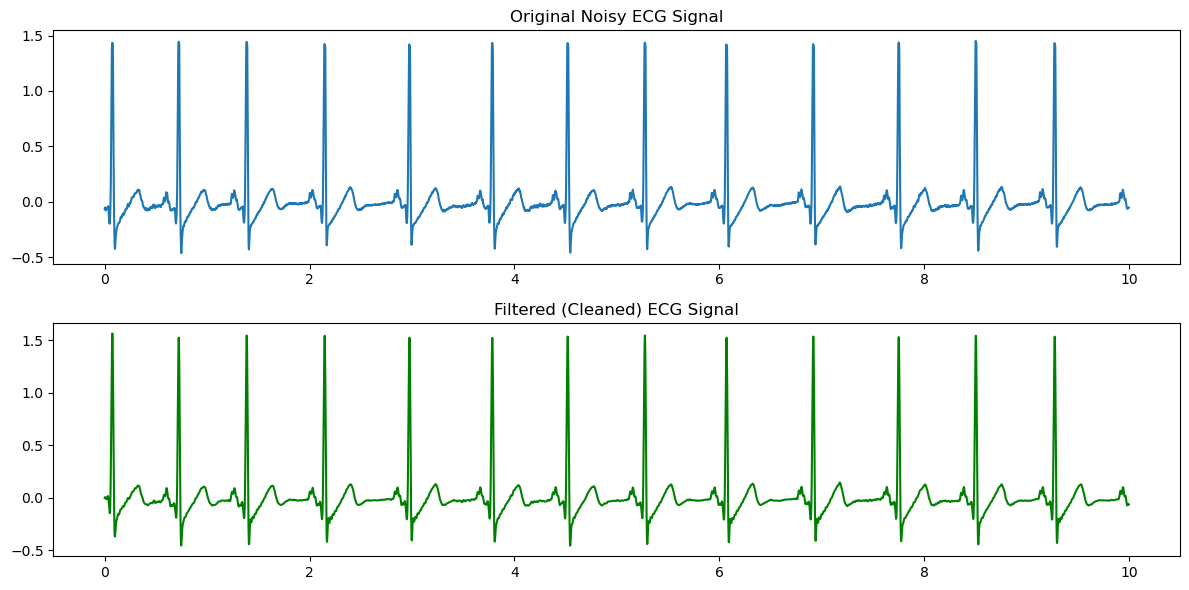

In [98]:
duration = len(ecg_resting_state['ECG1'].tolist()) / sampling_rate
t = np.linspace(0, duration , len(ecg_resting_state['ECG1']))
t = t[:5000]

# Cleaning methods
ecg_cleaned = nk.ecg_clean(ecg_resting_state['ECG1'], sampling_rate=sampling_rate, method='neurokit') 

# Step 3: Calculate signal power (variance of the cleaned ECG signal)
signal_power = np.var(ecg_cleaned)

# Step 4: Estimate noise power (using residual noise after subtracting cleaned signal from noisy signal)
noise_signal = ecg_resting_state['ECG1'] - ecg_cleaned  # residual noise
noise_power = np.var(noise_signal)

# Step 5: Calculate SNR (Signal-to-Noise Ratio in dB)
snr = 10 * np.log10(signal_power / noise_power)

# Output the results
print(f"Signal Power: {signal_power}")
print(f"Noise Power: {noise_power}")
print(f"SNR: {snr} dB")

# Optional: Plot the original noisy signal and the cleaned ECG signal for visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, ecg_resting_state['ECG1'].tolist()[:5000], label="Noisy ECG")
plt.title("Original Noisy ECG Signal")
plt.subplot(2, 1, 2)
plt.plot(t, ecg_cleaned[:5000], label="Cleaned ECG", color='g')
plt.title("Filtered (Cleaned) ECG Signal")
plt.tight_layout()
plt.show()
